# Did someone say SALE?!?
## *Web scraping and analyzing REI's deals*

![Home](Photos/Home.png)

Have you ever wondered about the products that go on sale at REI?

Whether men's and women's items are discounted differenty? <br>
If reviews are related to product discounts? <br>
Which brands have the steepest markdowns?

Maybe you're helplessly drawn to the A/B tester's bright red <span style="color:red">Deals</span> button and want to find the second-cheapest Patagonia product with at least 4.9 stars to give your mom for her birthday.

Perhaps you just want to learn something about web scraping, data visualization, and hypothesis testing in Python.

Either way, you're in luck!

## Goals:

- **Scrape every discounted product from https://www.rei.com**
- **Return a structured pandas dataframe**
- **Visualize the data**
- **Perform some preliminary hypothesis tests**

This notebook assumes some elementary exposure to Python, but it should be beginner friendly!

## Packages and libraries

We will use `requests` and `BeautifulSoup` to download and parse the data from REI's website.

We will use `pandas`, `matplotlib`, and `seaborn` to organize and visualize the data.

You can install `BeautifulSoup` in a Jupyter Notebook by typing `conda install BeautifulSoup4`.

You can also use `pip install BeautifulSoup4` from the command line.

You can install the other packages in the same manner.

Once all the packages and libraries are installed, we import them like so:

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load the website

To extract the data we need, we need the right URL. The Deals section of the REI website is found here: https://www.rei.com/h/deals.

![Categories](Photos/Categories.png)

Where to start? It appears that we have to choose between "top deals", deals by category, brand, or another clasification.

Let's begin with a single category (climbing, of course). Here is the URL for the climbing category, with 90 products per page selected: https://www.rei.com/c/climbing/f/scd-deals?pagesize=90.

Now we need to inspect the page in order to access the HTML structure beneath. We can do this by right-clicking anywhere on the page and then clicking 'Inspect', or by selecting View -> Developer -> Developer Tools on Google Chrome. The process is similar on other browsers.

![HTML](Photos/HTML.png)

There should now be a sidebar with a lot of information.

## Scrape data from the HTML

We will use the libraries `Requests` and `Beautiful Soup` to load our URL, parse the underlying HTML, and extract the data we need.

In [2]:
# Load the URL
url = 'https://www.rei.com/c/climbing/f/scd-deals?pagesize=90'

In [3]:
# Download the page content from the URL
res = requests.get(url)
res.raise_for_status

<bound method Response.raise_for_status of <Response [200]>>

Response [200] means our request was fulfilled.

In [4]:
# Parse the web page into a Beautiful Soup object
soup = BeautifulSoup(res.text,'html.parser')

![Box](Photos/Box.png)

If we explore the website a little, we discover that each product is stored under a `li` parent tag with the attribute `class="pPe0GNuagvmEFURs1Q_vm"`.

The tag is opened with `<li ...>` and closed with `</li>`. Inside the tag is all the information for the given product, including other tags with the item name, brand, price, etc.

`BeautifulSoup` has two useful methods for finding tags like these. Use `.find()` to find the first tag fitting given criteria, and `.findall()` to return a list of all tags fitting the criteria.

Here we want every product on the page, so we use `.find_all()` to search for `li` tags with `class="pPe0GNuagvmEFURs1Q_vm"`.

In [5]:
# Get all the products with the given tag and class
products = soup.find_all('li', attrs = {'class':'pPe0GNuagvmEFURs1Q_vm'})

In [6]:
# View the number of products on this page
len(products)

46

## Extract data from each product

Now that we have a list of products, what information do we need from each product? For starters:
- Name
- Brand
- Sale price
- Original price

It could also be interesting to look at:
- Gender category
- Average reviews
- The number of carousel images

We will extract this information and store the results in a pandas dataframe.

### Product names

Let's begin with product names. Product names are stored in a `span` tag with the attribute `data-ui="product-title"`. Let's loop through each product and store its name in a list, which we will add to our dataframe later. We access the text contained in each tag with the `.string` attribute.

In [7]:
# Scrape the product names
product_names = []
for product in products:
    product_names.append(product.find('span', attrs = {'data-ui':'product-title'}).string)

In [8]:
# Check the number of product names (it should be the same as the number of products)
len(product_names)

46

In [9]:
# Look at the first 5 names
product_names[0:5]

["Zenit Climbing Shoes - Men's",
 'ECO Camo Chalk Bag',
 'Zone LV Climbing Shoes',
 "Orion Harness - Men's",
 "Solaris Harness - Women's"]

### Product brands

Brands are stored in a `span` tag with the attribute `data-ui="product-brand"`. Let's repeat the previous process to get a list of brands.

In [10]:
# Scrape the brand names
brand_names = []
for product in products:
    brand_names.append(product.find('span', attrs = {'data-ui':'product-brand'}).string)

In [11]:
# Check the number of sale prices and look at the first 5
print(len(brand_names))
brand_names[0:5]

46


['La Sportiva', 'So iLL', 'Black Diamond', 'Edelrid', 'Edelrid']

### Sale prices

Sale prices are stored in a `span` tag with the attribute `data-ui="sale-price"`. Let's repeat the previous process to get a list of sale prices. We also remove each "\\$".

In [12]:
# Scrape the sale prices
sale_prices = []
for product in products:
    sale_prices.append(product.find('span', attrs = {'data-ui':'sale-price'}).string.strip("$"))

In [13]:
# Check the number of sale prices and look at the first 5
print(len(sale_prices))
sale_prices[0:5]

46


['65.83', '16.93', '73.73', '64.93', '64.93']

### Original prices

Must original prices are stored in a `span` tag with the attribute `data-ui="compare-at-price"`. But for whatever reason, some are stored in a different `span` tag with the attribute `data-ui="full-price"`.

In [14]:
# Scrape the original prices
original_prices = []
for product in products:
    original_prices.append(product.find('span', attrs = {'data-ui':'compare-at-price'}))

When we attemp to access the `.string` attribute of the nonexistent tags, we get an error.

In [15]:
# View the first 15 original prices
original_prices[0:15]

[<span data-ui="compare-at-price">$165.00</span>,
 <span data-ui="compare-at-price">$34.00</span>,
 <span data-ui="compare-at-price">$139.95</span>,
 <span data-ui="compare-at-price">$129.95</span>,
 <span data-ui="compare-at-price">$129.95</span>,
 None,
 <span data-ui="compare-at-price">$169.95</span>,
 None,
 <span data-ui="compare-at-price">$120.00</span>,
 <span data-ui="compare-at-price">$165.00</span>,
 <span data-ui="compare-at-price">$69.95</span>,
 <span data-ui="compare-at-price">$699.00</span>,
 <span data-ui="compare-at-price">$33.95</span>,
 <span data-ui="compare-at-price">$179.95</span>,
 <span data-ui="compare-at-price">$44.00</span>]

If we do a little digging, we discover that both of the prices we want have tags named `span` and "\\$" in the text. The only problem is that the sale price also matches these conditions. Since the sale price always comes before the original price, we can use `find_all` with our conditions and select the second text element (the first being the sale price).

In [16]:
# Scrape the original prices, searching for tags names 'span' with text containing '$'
original_prices = []
for product in products:
    original_prices.append(product.find_all(lambda tag:tag.name=="span" and "$" in tag.text)[1].text)

In [17]:
# View the first 15 original prices
original_prices[0:15]

['compared to \xa0$165.00',
 'compared to \xa0$34.00',
 'compared to \xa0$139.95',
 'compared to \xa0$129.95',
 'compared to \xa0$129.95',
 ' - $84.95',
 'compared to \xa0$169.95',
 ' - $139.00',
 'compared to \xa0$120.00',
 'compared to \xa0$165.00',
 'compared to \xa0$69.95',
 'compared to \xa0$699.00',
 'compared to \xa0$33.95',
 'compared to \xa0$179.95',
 'compared to \xa0$44.00']

That looks better! The `None` elements from the previous list are replaced with original prices. Since the formats of the strings differ, we need to extract only the part after "\\$" (the price). We can do this with a simple list comprehension.

In [18]:
# Return only the price for each string in the list
original_prices = [s.split('$')[1] for s in original_prices]

In [19]:
# View the first 15 original prices
original_prices[0:15]

['165.00',
 '34.00',
 '139.95',
 '129.95',
 '129.95',
 '84.95',
 '169.95',
 '139.00',
 '120.00',
 '165.00',
 '69.95',
 '699.00',
 '33.95',
 '179.95',
 '44.00']

Looks great!

### Gender

REI has a number of gender categories for their products. Each category is represented in the product name (e.g., 'Name - Women's).

Let's create a new list based on `product_names` to get the gender for each product.

Product names can contain more information after the " - " than just gender (e.g., model year or set information). We are going to categorize products into Men's, Women's, Kids', or Unisex. Later on, we will use a more comprehensive list of categories.

In [20]:
# Define REI gender categories
categories = ["Men's","Women's","Kids'"]

We will create a list of genders by splitting product names by " - ". We check first if multiple strings are returned (" - " exists in the string). If so, we return the second part if that string is one of our gender categories. If there is no match or no delimiter we return "Unisex".

In [21]:
# Create a list of genders
genders = [s.split(" - ")[1] if (len(s.split(" - "))>1) and (s.split(" - ")[1] in categories) else "Unisex" for s in product_names]

In [22]:
# Check the number of gender categories and look at the first 5
print(len(genders))
genders[0:5]

46


["Men's", 'Unisex', 'Unisex', "Men's", "Women's"]

### Average reviews

Review information is stored in a `span` tag with the attribute `class="cdr-rating__caption-sr_11-1-0"`.

In [23]:
# Scrape reviews
reviews = []
for product in products:
    reviews.append(product.find('span', attrs = {'class':'cdr-rating__caption-sr_11-1-0'}).string)

In [24]:
# Check the number of reviews and look at the first 5
print(len(reviews))
reviews[0:5]

46


['19 reviews with an average rating of 4.2 out of 5 stars',
 '0 reviews',
 '32 reviews with an average rating of 3.5 out of 5 stars',
 '0 reviews',
 '4 reviews with an average rating of 4.3 out of 5 stars']

Note that our results recognize that some products have no reviews. Sweet!

Each string contains two pieces of information, the number of reviews and the average rating. Let's split `reviews` into two lists, `reviews_number` and `reviews_rating`.

In [25]:
# Create two new lists by splitting each string in `reviews`
reviews_number,reviews_rating = zip(*(s.split(" reviews") for s in reviews))

In [26]:
# Check the number of review counts and look at the first 5
print(len(reviews_number))
reviews_number[0:5]

46


('19', '0', '32', '0', '4')

For `reviews_rating`, we need to strip everything except the rating number, which occurs at the index `s[27:30]`.

In [27]:
reviews_rating = [s[27:30] for s in reviews_rating]

In [28]:
# Check the number of review counts and look at the first 5
# Products with no reviews should have a rating of ''
print(len(reviews_rating))
reviews_rating[0:5]

46


['4.2', '', '3.5', '', '4.3']

###  Number of carousel images

Is the number of images displayed per product related to its discount? Let's see!

Each product has a certain number of associated images that the viewer can scroll through in a carousel. Each of those images is contained in a `li` tag. There are no other `li` tags within each product. We can count the number of images by counting the number of `li` tags in each product.

In [29]:
# Define a function to count `li` tags
def count_images(product):
    """Returns the number of carousel images of a product on REI's website"""
    temp = product.find_all('li')
    number = len(temp)
    return number

In [30]:
# Count the number of carousel images for each product
number_images = []
for product in products:
    number_images.append(count_images(product))

In [31]:
# Check the number of counts and look at the first 15
print(len(number_images))
number_images[0:15]

46


[6, 11, 3, 1, 2, 1, 6, 6, 6, 6, 1, 2, 1, 5, 7]

### Create a dataframe

Let's put it together! We can unite all of our lists into one pandas dataframe.

In [32]:
# Create a dataframe with our lists
climbing_deals = pd.DataFrame(list(zip(product_names,brand_names,genders,
                                       sale_prices,original_prices,reviews_number,
                                       reviews_rating,number_images)),
                              columns = ['product_name','brand_name','gender_category',
                                         'sale_price','original_price','number_reviews',
                                         'reviews_rating', 'number_images'])

In [33]:
# View the top 5 rows
climbing_deals.head()

,product_name,brand_name,gender_category,sale_price,original_price,number_reviews,reviews_rating,number_images
0,Zenit Climbing Shoes - Men's,La Sportiva,Men's,65.83,165.00,19,4.2,6
1,ECO Camo Chalk Bag,So iLL,Unisex,16.93,34.00,0,,11
2,Zone LV Climbing Shoes,Black Diamond,Unisex,73.73,139.95,32,3.5,3
3,Orion Harness - Men's,Edelrid,Men's,64.93,129.95,0,,1
4,Solaris Harness - Women's,Edelrid,Women's,64.93,129.95,4,4.3,2


Cool!

## Scaling the process for all discounted products

So far, we have scraped information for discounted items in the climbing category and created a structured dataframe.

We now need to find a way to scrape *all* discounted products. There are many, many more products in other categories, so it is important to be efficient.

REI's website has a page for all deals - https://www.rei.com/f/scd-deals?pagesize=90. We will use this URL to scrape all products that are currently discounted.

Notice that all of the products do not fit on the first page. In fact, the first page only holds a small proportion of all the discounted products.

We can access the rest of the products by successively clicking through the arrow button `>` and scraping as we go.

![Pages](Photos/Pages.png)

The load more `>` button is stored in a `span` tag with "Go to next page" in the text. We can check if the current page lacks the load more button (meaning we are on the last page of products) by seeing whether the length of `buttons` is 0.

In [34]:
# Find the load more button
buttons = soup.find_all(lambda tag:tag.name=="span" and "Go to next page" in tag.text)

In [35]:
len(buttons)

0

The URLs for the pages following the first look like this:
- https://www.rei.com/f/scd-deals?pagesize=90&page=2
- https://www.rei.com/f/scd-deals?pagesize=90&page=3
- And so on...

If the load more button exists, we will append '&page=2', '&page=3', etc. to the inputted URL and loop through each page in turn.

### Define a function

Now we define a function to scrape every discounted product. There are a few things we have to keep in mind.

There are many pages that we have to load and parse, with many products on each page. In the previous sections, we looped through the loaded products every time we wanted more information. This time, we will only loop through the products one time per page and extract all the information at once.

This function contains a more comprehensive list of gendered categories, although the vast majority of products are either Men's, Women's, Kids' or Unisex.

In [36]:
def rei_deals_scrape(url):
    """
    Scrapes and returns data about discounted items on the REI website.
    
    Scrapes data from the REI deals website and returns a pandas dataframe with product names,
    brand names, gender categories, sale prices, original prices, number of reviews, review rating, 
    and number of carousel images.
    
    Parameter url is the url of the website.
    """
    # Store the URL
    base_url = url
    
    # Define the list of dataframes
    deals_data = []
    
    # Define REI gender categories
    categories = ["Men's","Women's","Women's/Kids'","Men's/Kids'","Kids'",
                  "Boys'","Girls'","Toddlers'/Kids'", "Big Kids'",
                  "Infants'","Infants'/Toddlers'",'Kids',"Kids'",
                  "Kids' Size 16","Kids' Size 8","Kids'/Toddlers'", 'Boys\' 17" Outseam',
                  "Little Kids'","Men's",'Men\'s 10" Inseam','Men\'s 10.5" Inseam',
                  'Men\'s 11" Inseam','Men\'s 12" Inseam','Men\'s 16" Outseam',
                  'Men\'s 17" Outseam','Men\'s 18" Outseam','Men\'s 18.5" Outseam',
                  'Men\'s 19" Outseam','Men\'s 21" Outseam','Men\'s 3" Inseam',
                  'Men\'s 32" Inseam','Men\'s 5" Inseam','Men\'s 5.5" Inseam',
                  'Men\'s 6" Inseam',"Men's 6'' Inseam","Men's 7 in. Inseam",
                  'Men\'s 7" Inseam','Men\'s 7" inseam','Men\'s 7.5" Inseam',
                  'Men\'s 8" Inseam','Men\'s 9" Inseam','Men\'s 9" inseam',
                  'Men\'s 9.5" Inseam',"Men's Big Sizes","Men's Big and Tall Sizes",
                  "Men's Long", "Men's Short Sizes", "Men's Tall Sizes",
                  "Men's Trail-Running Shoes","Toddler Boys'","Toddler Boys'/Boys'",
                  "Toddler Girls'","Toddler Girls'/Girls'","Toddlers'",
                  'Toddlers\' 14" Outseam', "Toddlers'/Kids'", "Toddlers'/Kids' Sizes 5-10",
                  "Toddlers'/Little Kids'",'Women\'s 10" Inseam','Women\'s 2.5" inseam',
                  'Women\'s 3" Inseam','Women\'s 4" Inseam','Women\'s 5" Inseam',
                  'Women\'s 5.5" Inseam','Women\'s 6" Inseam','Women\'s 7" Inseam',
                  'Women\'s 9" Inseam', "Women's Long", "Women's Petite",
                  "Women's Petite Sizes", "Women's Plus Size", "Women's Plus Sizes",
                  "Women's Short", "Women's Short Sizes", "Women's Tall Sizes",
                  "Women's/Kids'",]

    # Define i as the page number, starting at 1    
    i = 1
    
    # Define a function to count `li` tags
    def countImages(product):
        """Returns the number of carousel images a product on REI's website"""
        temp = product.find_all('li')
        number = len(temp)
        return number

    # Loop through each page until there are no more pages
    while True:
        # Download the page content from the URL
        res = requests.get(url)
        res.raise_for_status
        
        # Parse the web page into a Beautiful Soup object
        soup = BeautifulSoup(res.text,'html.parser')
        
        # Get all the products displayed on the page
        products = soup.find_all('li', attrs = {'class':'pPe0GNuagvmEFURs1Q_vm'})

        # Define empty lists to store our information
        product_names = []
        brand_names = []
        sale_prices = []
        original_prices = []
        reviews = []
        number_images = []

        # Loop through products and extract the information we want
        for product in products:
            # Product names
            product_names.append(product.find('span', attrs = {'data-ui':'product-title'}).string)

            # Brand names
            brand_names.append(product.find('span', attrs = {'data-ui':'product-brand'}).string)

            # Sale prices
            sale_prices.append(product.find('span', attrs = {'data-ui':'sale-price'}).string.strip('$'))

            # Original prices
            original_prices.append(product.find_all(lambda tag:tag.name=="span" and "$" in tag.text)[1].text.split('$')[1])

            # Gender categories
            genders = [s.split(" - ")[1] if (len(s.split(" - "))>1) and (s.split(" - ")[1] in categories) else "Unisex" for s in product_names]

            # Reviews
            reviews.append(product.find('span', attrs = {'class':'cdr-rating__caption-sr_11-1-0'}).string)
            reviews_number,reviews_rating = zip(*(s.split(" reviews") for s in reviews))
            reviews_rating = [s[27:30] for s in reviews_rating]

            # Number of carousel images
            number_images.append(countImages(product))

            # Create a dataframe with our lists
            deals = pd.DataFrame(list(zip(product_names,brand_names,genders,
                                                   sale_prices,original_prices,reviews_number,
                                                   reviews_rating,number_images)),
                                          columns = ['product_name','brand_name','gender_category',
                                                     'sale_price','original_price','number_reviews',
                                                     'reviews_rating', 'number_images'])
        
        # Add the current dataframe to the existing list
        deals_data.append(deals)

        # Find the load more button
        buttons = soup.find_all(lambda tag:tag.name=="span" and "Go to next page" in tag.text)

        # If the load more button exists, move on to the next url. If not, end the loop.
        if len(buttons) == 0:
            break
        else:
            print(f"Scraping page {str(i)}...")
            i+=1
            url = base_url + '&page=' + str(i)
    
    print("Done!")
    
    # Concatenate the list of dataframes together
    deals_data = pd.concat(deals_data)
    
    return(deals_data)

In [37]:
# Call the function on the "Shop all deals" URL
deals_data = rei_deals_scrape('https://www.rei.com/f/scd-deals?pagesize=90')

Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...
Scraping page 18...
Scraping page 19...
Scraping page 20...
Scraping page 21...
Scraping page 22...
Scraping page 23...
Scraping page 24...
Scraping page 25...
Scraping page 26...
Scraping page 27...
Scraping page 28...
Scraping page 29...
Scraping page 30...
Scraping page 31...
Scraping page 32...
Scraping page 33...
Scraping page 34...
Scraping page 35...
Scraping page 36...
Scraping page 37...
Scraping page 38...
Scraping page 39...
Scraping page 40...
Scraping page 41...
Scraping page 42...
Scraping page 43...
Scraping page 44...
Scraping page 45...
Scraping page 46...
Scraping page 47...
Scraping page 48...
Scraping page 49...
Scraping page 50...
Scraping 

In [38]:
deals_data

,product_name,brand_name,gender_category,sale_price,original_price,number_reviews,reviews_rating,number_images
0,Sahara Path Pants - Men's,REI Co-op,Men's,34.83,69.95,151,4.5,4
1,Divide+ Push 425L LED Lantern,Coleman,Unisex,11.73,24.99,72,4.0,2
2,Recycled Flying Disc,REI Co-op,Unisex,4.93,12.95,3,5.0,2
3,Siesta Hooded 25 Double Sleeping Bag,REI Co-op,Unisex,113.93,229.00,73,4.2,5
4,Cross Hike Mid GTX Hiking Boots - Men's,Salomon,Men's,84.83,170.00,228,3.5,8
...,...,...,...,...,...,...,...,...
2,Heavy Vibes Socks,Poler,Unisex,7.73,12.00,0,,1
3,CoffeePress,BioLite,Unisex,8.73,14.95,0,,8
4,ErgoBuoy Pull Buoy,Aqua Sphere,Unisex,8.73,24.99,1,1.0,1
5,Purist Water Bottle - 22 fl. oz.,Co-op Cycles,Unisex,6.93,9.95,65,4.7,3


In [39]:
deals_data.shape

(6307, 8)

Wow, that's a lot of deals!

## Clean the data

Let's first examine the data types of each column.

In [40]:
deals_data.dtypes

product_name       object
brand_name         object
gender_category    object
sale_price         object
original_price     object
number_reviews     object
reviews_rating     object
number_images       int64
dtype: object

We will convert `sale_price`, `original_price`, and `reviews rating` to `float`, and `number_reviews` to `int`.

Before we do that, we need to make sure that there are no confusing characters.

Some products have a price range that includes "-" instead of a single price (different options with different prices). We will remove these from our dataframe.

Prices in the $1,000s have commas that we need to take out.

Finally, we need to replace the empty strings in the `reviews_rating` column with `Nan` values.

In [41]:
# Remove products with price ranges
print(f"{((deals_data.sale_price.str.contains('-').sum() + deals_data.original_price.str.contains('-').sum())/deals_data.shape[0]*100):.2f}% of data removed.")
deals_data = deals_data[~deals_data.sale_price.str.contains("-")]
deals_data = deals_data[~deals_data.original_price.str.contains("-")]

3.12% of data removed.


In [42]:
# Remove commas
deals_data['sale_price'] = deals_data['sale_price'].str.replace(',','')
deals_data['original_price'] = deals_data['original_price'].str.replace(',','')

In [43]:
# Replace empty strings with NaN
deals_data['reviews_rating'] = deals_data['reviews_rating'].replace(r'^\s*$', np.nan, regex=True)

In [44]:
# Convert to new data types
deals_data = deals_data.astype({'sale_price':'float','original_price':'float',
                                'number_reviews':'int','reviews_rating':'float'})

In [45]:
deals_data.dtypes

product_name        object
brand_name          object
gender_category     object
sale_price         float64
original_price     float64
number_reviews       int64
reviews_rating     float64
number_images        int64
dtype: object

Finally, let's take a look at the gender categories and try to simplify them a bit.

We will put every product into one of four categores:
- Women's: any category tag that mentions women.
- Men's: any category tag that mentions men.
- Kids': any category tag that mentions kids, boys, girls, toddlers, or infants.
- Unisex: anything else.

In [46]:
# Define new gender category terms
categories_women = ["Women's","Women's/Kids'",'Women\'s 10" Inseam','Women\'s 2.5" inseam',
                  'Women\'s 3" Inseam','Women\'s 4" Inseam','Women\'s 5" Inseam',
                  'Women\'s 5.5" Inseam','Women\'s 6" Inseam','Women\'s 7" Inseam',
                  'Women\'s 9" Inseam', "Women's Long", "Women's Petite",
                  "Women's Petite Sizes", "Women's Plus Size", "Women's Plus Sizes",
                  "Women's Short", "Women's Short Sizes", "Women's Tall Sizes",
                  "Women's/Kids'",]

categories_men = ["Men's","Men's/Kids'","Men's",'Men\'s 10" Inseam','Men\'s 10.5" Inseam',
                  'Men\'s 11" Inseam','Men\'s 12" Inseam','Men\'s 16" Outseam',
                  'Men\'s 17" Outseam','Men\'s 18" Outseam','Men\'s 18.5" Outseam',
                  'Men\'s 19" Outseam','Men\'s 21" Outseam','Men\'s 3" Inseam',
                  'Men\'s 32" Inseam','Men\'s 5" Inseam','Men\'s 5.5" Inseam',
                  'Men\'s 6" Inseam',"Men's 6'' Inseam","Men's 7 in. Inseam",
                  'Men\'s 7" Inseam','Men\'s 7" inseam','Men\'s 7.5" Inseam',
                  'Men\'s 8" Inseam','Men\'s 9" Inseam','Men\'s 9" inseam',
                  'Men\'s 9.5" Inseam',"Men's Big Sizes","Men's Big and Tall Sizes",
                  "Men's Long", "Men's Short Sizes", "Men's Tall Sizes",
                  "Men's Trail-Running Shoes",]

categories_kids = ["Kids'","Boys'","Girls'","Toddlers'/Kids'", "Big Kids'",
                  "Infants'","Infants'/Toddlers'",'Kids',"Kids'",
                  "Kids' Size 16","Kids' Size 8","Kids'/Toddlers'", 'Boys\' 17" Outseam',
                  "Little Kids'","Toddler Boys'","Toddler Boys'/Boys'",
                  "Toddler Girls'","Toddler Girls'/Girls'","Toddlers'",
                  'Toddlers\' 14" Outseam', "Toddlers'/Kids'", "Toddlers'/Kids' Sizes 5-10",
                  "Toddlers'/Little Kids'",]

We define three masks to filter to products in `deals_data` that are in the women's, men's, or kids' categories.

In [47]:
# Define masks for women's, men's, and kids' categories
mask_w = deals_data.gender_category.isin(categories_women)
mask_m = deals_data.gender_category.isin(categories_men)
mask_k = deals_data.gender_category.isin(categories_kids)

In [48]:
# Set new gender categories based on the masks
deals_data.loc[mask_w,'gender_category'] = "Women's"
deals_data.loc[mask_m,'gender_category'] = "Men's"
deals_data.loc[mask_k,'gender_category'] = "Kids'"

In [49]:
deals_data.gender_category.value_counts()

Women's    2557
Men's      1574
Unisex     1405
Kids'       617
Name: gender_category, dtype: int64

Before we move on, we will add one more column `percent_discount` that is the percentage difference between the sale price and original price.

In [50]:
# Add a new column with the percent discount
deals_data['percent_discount'] = 100*(deals_data['original_price']-deals_data['sale_price'])/deals_data['original_price']

In [51]:
# Look at 10 most discounted products
deals_data.nlargest(10,'percent_discount')

,product_name,brand_name,gender_category,sale_price,original_price,number_reviews,reviews_rating,number_images,percent_discount
20,Multifunctional Tube,Chaos,Unisex,1.73,14.99,80,3.7,4,88.458973
24,Hallena Pants - Women's,prAna,Women's,17.73,89.00,17,3.7,2,80.078652
50,Rim Tape - 18mm Wide,Orange Seal,Unisex,2.93,13.00,1,1.0,1,77.461538
44,St. Barth Swimsuit Bottoms - Women's,Carve Designs,Women's,9.73,42.00,1,5.0,4,76.833333
40,Flash Insulated Jacket - Men's,REI Co-op,Men's,34.83,149.00,112,4.3,1,76.624161
79,Sweet Summer Rib Frill Tank One-Piece Swimsuit...,Seafolly,Kids',13.73,58.00,0,NaN,1,76.327586
3,Sun Dreamer Stripe Tank One-Piece Swimsuit - G...,Seafolly,Kids',13.73,58.00,0,NaN,1,76.327586
49,Frankie Tank Top - Women's,Carve Designs,Women's,14.73,62.00,3,3.3,3,76.241935
43,Mesh Tank Top - Thistle - Girls',Threads 4 Thought,Unisex,6.73,28.00,0,NaN,3,75.964286
22,BRT615 (B01S) Resin Disc Brake Pads,Shimano,Unisex,1.93,8.00,11,4.4,1,75.875000


## Explore the data

What advantages do we have already over the functionality of REI's website?

The website allows you to filter by brand or gender and sort by price, percent discount, or review ratings, but combining multiple criteria grows clunky, and it is impossible to sort by multiple criteria.

A quick comparison between the most discounted products above and the results of the website when sorted by percent discount reveals that products discounted over 80% are not even displayed! You can find them searching manually by name, but they do not automatically populate when sorted. Interesting!

To demonstrate the power of our dataframe, let's look at all products with at least 100 reviews and a rating of at least 4.9 stars (number of reviews is not a criteria on the website).

In [52]:
# Return products with at least 100 reviews and 4.9 stars
deals_data[(pd.to_numeric(deals_data.number_reviews)>=100) & (pd.to_numeric(deals_data.reviews_rating)>=4.9)]

,product_name,brand_name,gender_category,sale_price,original_price,number_reviews,reviews_rating,number_images,percent_discount
52,Reversible Mossbud Swirl Parka - Girls',The North Face,Kids',95.73,129.0,138,4.9,5,25.790698
79,Neo-Classic Rain Boots - Toddlers'/Kids',Bogs,Kids',69.73,90.0,114,4.9,4,22.522222
26,Hike+ Light Crew Socks - Men's,Icebreaker,Men's,16.73,22.0,343,4.9,1,23.954545
77,Play Hat - Toddlers'/Kids',Sunday Afternoons,Kids',20.73,29.0,592,4.9,2,28.517241


Let's generate some descriptive statistics of our dataframe. The `.describe()` method returns the count, mean, standard deviation, minimum, percentiles, and maximum for all numeric columns by default.

In [53]:
# Describe the numeric columns
deals_data.describe()

,sale_price,original_price,number_reviews,reviews_rating,number_images,percent_discount
count,6153.000000,6153.000000,6153.000000,4401.000000,6153.000000,6153.000000
mean,80.879579,124.410588,31.669592,4.116496,4.168211,37.154947
std,154.593184,202.308235,187.622867,0.861437,2.631487,14.229762
min,1.730000,4.750000,0.000000,1.000000,1.000000,-11.235206
25%,29.730000,52.000000,0.000000,3.800000,2.000000,25.397059
50%,49.830000,80.000000,2.000000,4.300000,4.000000,30.908000
75%,89.730000,139.950000,12.000000,4.700000,6.000000,50.130769
max,5439.930000,6800.000000,6387.000000,5.000000,11.000000,88.458973


What does this tell us? A few things jump out:
- `sale_price` and `original_price` have a large coefficiant of variation (ratio of standard deviation to the mean), meaning that dispersion is high (the data is stretched).
- The mean of `sale_price` and `original_price` is greater than the median, and close to the 75th percentile. The maximum values for `sale_price` and `original_price` are much farther from the mean than the minimum values. This suggests that the data is skewed to the right.
- `number_reviews` also appears to be highly dispersed and highly positively skewed.
- `reviews_rating` appears to be less dispersed and negatively skewed.
- `number_images` might have more of a normal distribution.
- `percent_discount` appears to be less dispersed and positively skewed (but less so than other columns).

We can also describe object columns to get the count, number of unique values, most common value, and frequency of the most common value.

In [54]:
# Describe the oject columns
deals_data.describe(include='object')

,product_name,brand_name,gender_category
count,6153,6153,6153
unique,5943,402,4
top,Dare Zip Bra,prAna,Women's
freq,3,308,2557


## Visualize and analyze the Data

Now let's visualize the data to get a better sense of the distributions. We will use the `seaborn` and `matplotlib` libraries.

### Percent discounts by gender category

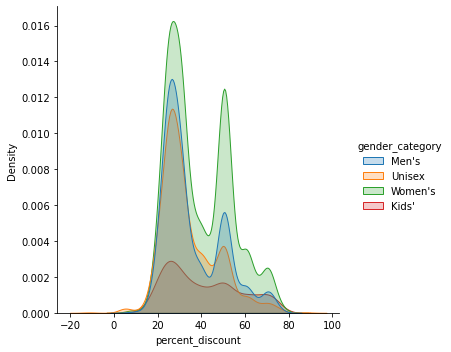

In [55]:
# Kernel density estimation of percent discount by gender category
sns.displot(data=deals_data, 
            x='percent_discount', 
#            col='gender_category',
            hue='gender_category', 
            kind='kde', 
            fill=True)

These are some funky distributions! It looks like Men's, Women's, and Unisex products follow a similar discounting strategy, with many products 25% and 50% off. Kids' products appear to have a more uniform discount percentage distribution.

Let's make some histograms to get more detail.

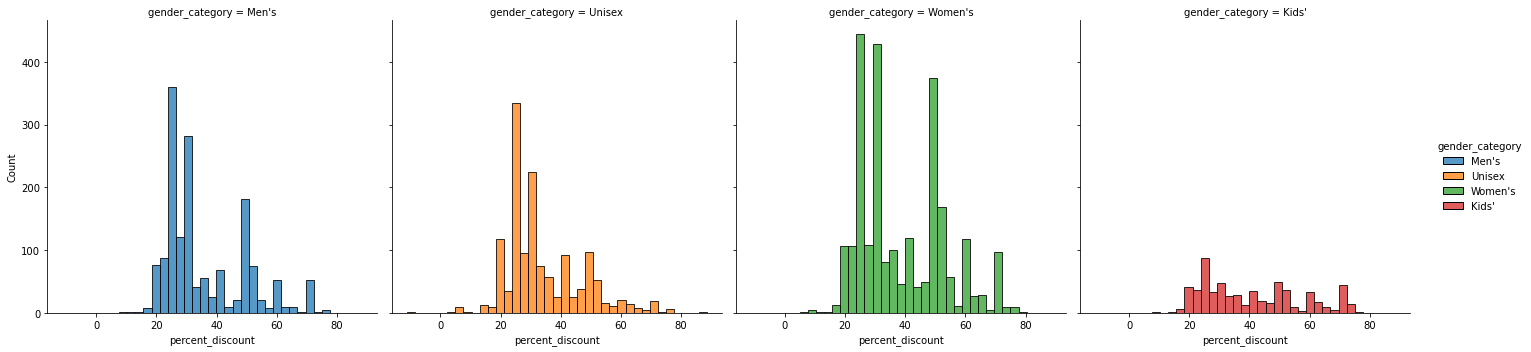

In [56]:
# Kernel density estimation of percent discount by gender category
sns.displot(data=deals_data, 
            x='percent_discount', 
            col='gender_category',
            hue='gender_category', 
#            kind='kde', 
            fill=True)

We see that several discount percentages are more common than others:
- 25%, 30%, 40%, 50%, 60%, 75% (especially 25%, 30%, and 50%)

Let's do a statistical test to see whether the groups originate from the same distribution. We will use the Kruskal-Wallis H test, a non-parametric alternative to ANOVA, because our distributions are clearly not normally distributed. Read more here:
- https://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html

In [57]:
# Import the stats module and the posthocs package
from scipy import stats
import scikit_posthocs as sp

In [58]:
# Create groups from the categories
mens = deals_data[deals_data.gender_category=="Men's"]['percent_discount']
womens = deals_data[deals_data.gender_category=="Women's"]['percent_discount']
unisex = deals_data[deals_data.gender_category=="Unisex"]['percent_discount']
kids = deals_data[deals_data.gender_category=="Kids'"]['percent_discount']

In [59]:
# Kruskal-wallis test
stats.kruskal(mens,womens,unisex,kids)

KruskalResult(statistic=145.53518674834152, pvalue=2.419991035017073e-31)

Our null hypothesis was that the groups all come from the same distribution (not that their medians are equal, since we are not assuming an equally scaled and shaped distribution across groups). At an alpha level of 0.05, we reject the null hypothesis. This does not tell us which of the groups differ, so we must do a post hoc comparison. We will use the Dunn test. Read more here:
- https://en.wikipedia.org/wiki/Dunnett%27s_test
- https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn/

In [60]:
# Dunn test with bonferroni p-adjustment for multiple comparisons
sp.posthoc_dunn(deals_data,val_col='percent_discount',group_col='gender_category',p_adjust = 'bonferroni') < 0.05

,Kids',Men's,Unisex,Women's
Kids',False,True,True,False
Men's,True,False,False,True
Unisex,True,False,False,True
Women's,False,True,True,False


At an alpha level of 0.05, every comparison is significant except for Women's-Kids' and Men's-Unisex. We reject the null hypothesis that there is no difference between groups except for the Women's-Kids' and Men's-Unisex comparisons. Although the distributions look different, we cannot conclude that they do not come from the same distribution.

In [61]:
# Describe percent discount by groups
deals_data.groupby('gender_category').percent_discount.describe()

,count,mean,std,min,25%,50%,75%,max
gender_category,,,,,,,,
Kids',617.0,40.808398,16.549836,10.270000,25.750000,37.080000,51.488889,76.327586
Men's,1574.0,35.682268,13.573773,7.746154,25.088125,30.188283,50.058333,76.624161
Unisex,1405.0,33.906523,12.707747,-11.235206,25.232616,30.087500,40.808081,88.458973
Women's,2557.0,38.964824,14.339590,5.580878,26.031818,33.740622,50.290290,80.078652


This suggests that REI uses a different discounting strategy for men's and women's products (at least as of October, 2022). Huh!

### Sale prices by gender category

Let's take a look at the distribution of sale prices by gender category. We limit the x-axis for better visibility because there is strong positive skew.

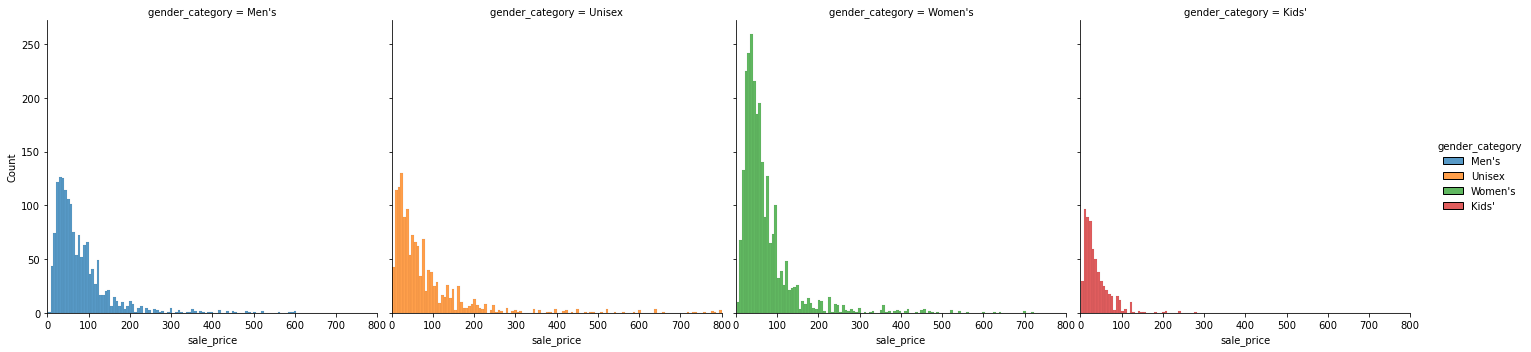

In [62]:
# Histogram of sale prices by gender category
sale_prices = sns.displot(data=deals_data, 
                          x='sale_price', 
                          col='gender_category',
                          hue='gender_category', 
#                          kind='kde', 
                          fill=True)

sale_prices.set(xlim=(0,800))

It looks like our observations were correct! The data is highly positively skewed with strong dispersion.

In [63]:
# Create groups from the categories
mens = deals_data[deals_data.gender_category=="Men's"]['sale_price']
womens = deals_data[deals_data.gender_category=="Women's"]['sale_price']
unisex = deals_data[deals_data.gender_category=="Unisex"]['sale_price']
kids = deals_data[deals_data.gender_category=="Kids'"]['sale_price']

We will repeat our statistical tests to see if there is a difference between groups.

In [64]:
# Kruskal-wallis test
stats.kruskal(mens,womens,unisex,kids)

KruskalResult(statistic=338.69432439430364, pvalue=4.183912396998193e-73)

In [65]:
# Dunn test with bonferroni p-adjustment for multiple comparisons
sp.posthoc_dunn(deals_data,val_col='sale_price',group_col='gender_category',p_adjust = 'bonferroni') < 0.05

,Kids',Men's,Unisex,Women's
Kids',False,True,True,True
Men's,True,False,True,True
Unisex,True,True,False,False
Women's,True,True,False,False


We find a significant difference (alpha = 0.05) between every group except Women's and Unisex. Again, it seems like REI is pricing men's and women's clothing differently.

In [66]:
# Describe percent discount by groups
deals_data.groupby('gender_category').sale_price.describe()

,count,mean,std,min,25%,50%,75%,max
gender_category,,,,,,,,
Kids',617.0,39.149838,34.088835,5.73,16.73,29.73,49.73,279.93
Men's,1574.0,81.113837,77.100304,4.83,34.93,59.73,99.73,839.93
Unisex,1405.0,113.686996,292.071702,1.73,24.83,51.93,104.73,5439.93
Women's,2557.0,72.777939,75.153675,3.83,32.93,49.93,83.73,839.93


## Some more plots!

We have learned that REI likely uses different pricing and discounting strategies for men's and women's products. We will now visualize some of the other data for fun. We could do additional statistical tests, but we will just stick with visualizations for now.

In [67]:
# Define a function to plot distributions with mean/stdev and median/quartiles
def my_plot(x):
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    for ax in axes:
        sns.kdeplot(x, shade=False, color='green', ax=ax)
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        if ax == axes[0]:
            middle = x.mean()
            sdev = x.std()
            left = middle - sdev
            right = middle + sdev
            ax.set_title('Showing mean and stdev')
        else:
            left, middle, right = np.percentile(x, [25, 50, 75])
            ax.set_title('Showing median and quartiles')
        ax.vlines(middle, 0, np.interp(middle, xs, ys), color='green', ls=':')
        ax.fill_between(xs, 0, ys, facecolor='green', alpha=0.2)
        ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='green', alpha=0.2)

### Reviews and discount percentage

One of our initial questions was whether reviews are related to product discounts. Let's create a scatter plot with a simple linear regression line.

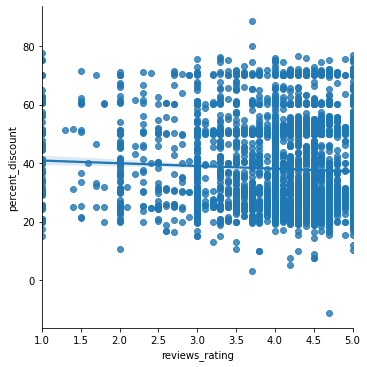

In [68]:
# Reviews and discount percentage
sns.lmplot(data=deals_data,x='reviews_rating',y='percent_discount')

It appears that there is a slight negative relationship between review rating and discount percentage.

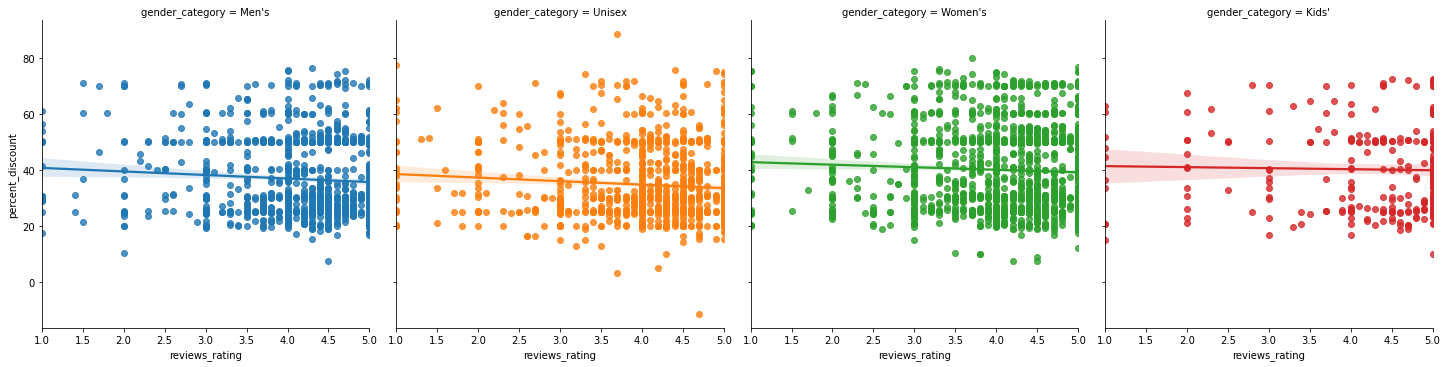

In [69]:
sns.lmplot(data=deals_data,x='reviews_rating',y='percent_discount',hue='gender_category',col='gender_category')

### Number of carousel images

Is the number of carousel images displayed for each product related to its percent discount or sale price?

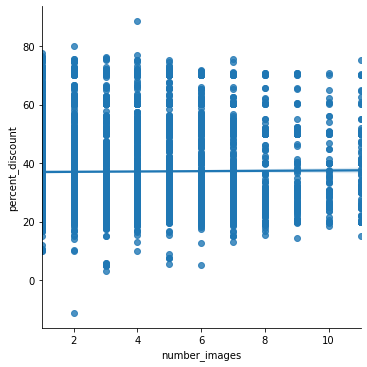

In [70]:
# Number of images and percent discount
sns.lmplot(data=deals_data,x='number_images',y='percent_discount')

There does not appear to be a clear relationship between the number of carousel images and discount percentage.

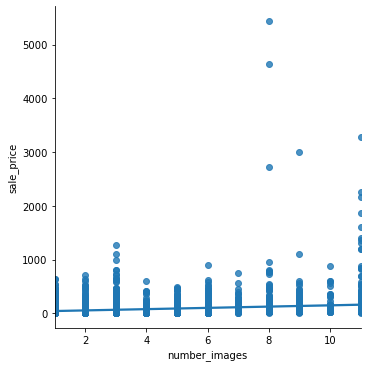

In [71]:
# Number of images and sale price
sns.lmplot(data=deals_data,x='number_images',y='sale_price')

It appears that there is a small positive relationship between the number of carousel images and sale price. Perhaps companies with higher-priced products care more about showing images of those products.

### Brand name and discount percentage

We were also curious if brand name is related to discount percentage. Let's filter to the nine brands with the most discounted items to make our job easier.

In [72]:
# Create a new dataframe with the top nine brands
top_brands = deals_data.brand_name.value_counts().head(9).index
brands_mask = deals_data.brand_name.isin(top_brands)
top_brands_data = deals_data.loc[brands_mask,:]

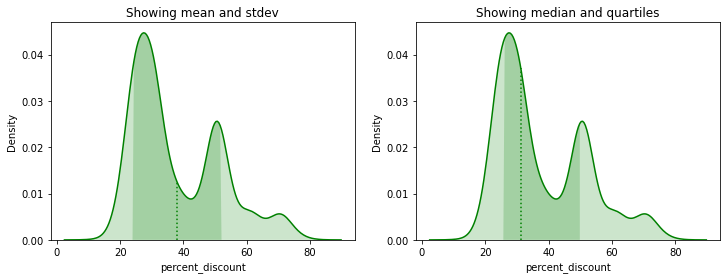

In [73]:
my_plot(top_brands_data.percent_discount)

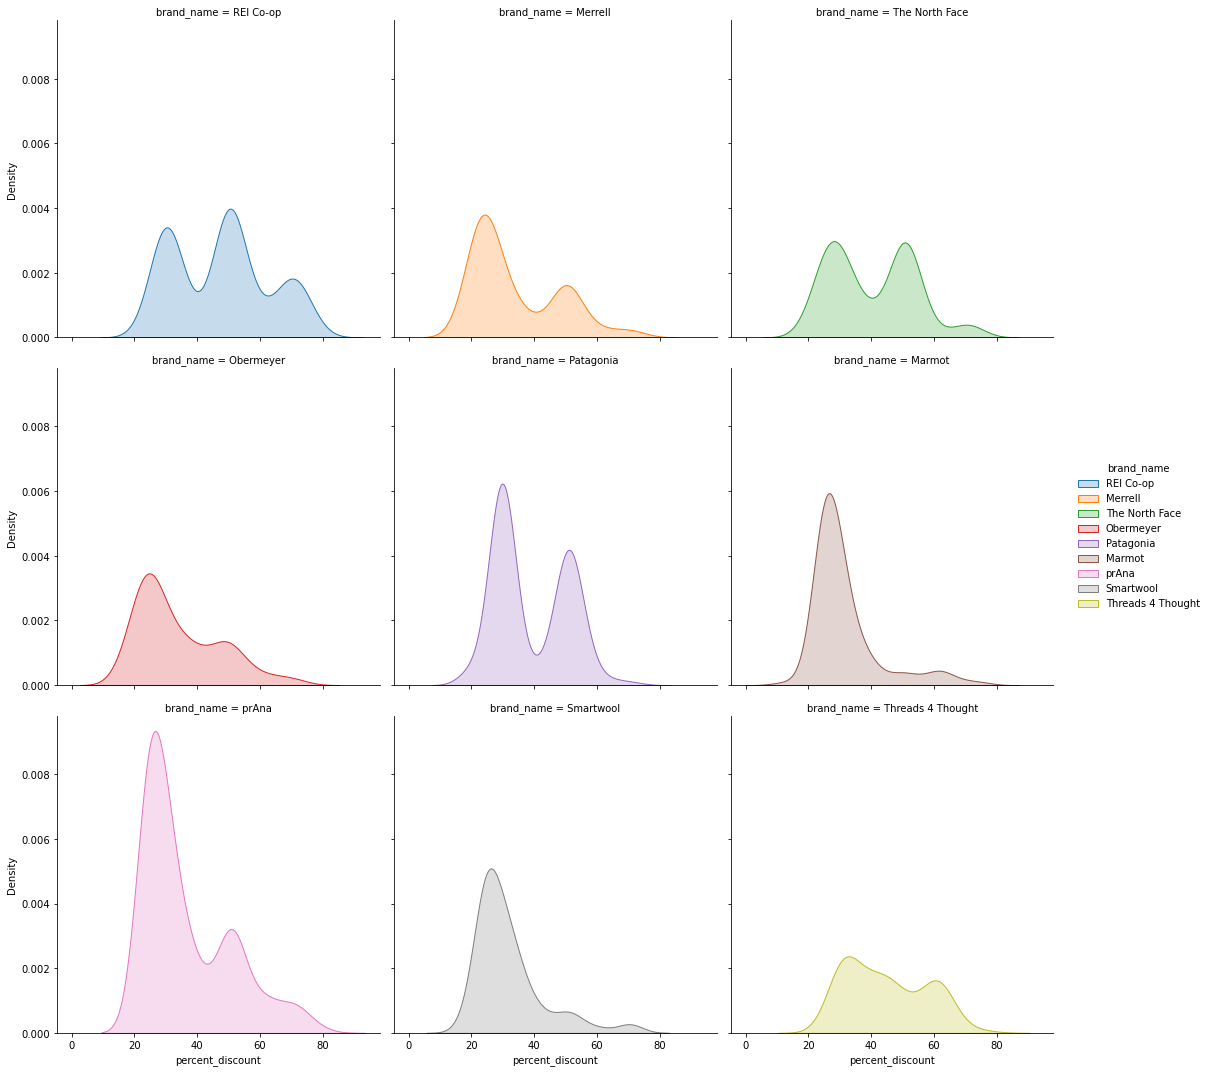

In [74]:
# Brand name and percent discount
sns.displot(data=top_brands_data, 
            x='percent_discount', 
            hue='brand_name', 
            col='brand_name',
            col_wrap=3,
            kind='kde', 
            fill=True)

Interesting! The top brands seem to have different discount percentage distributions (although most of them have peaks around 25% and 50%). Perhaps each brand communicates their own strategy to REI.

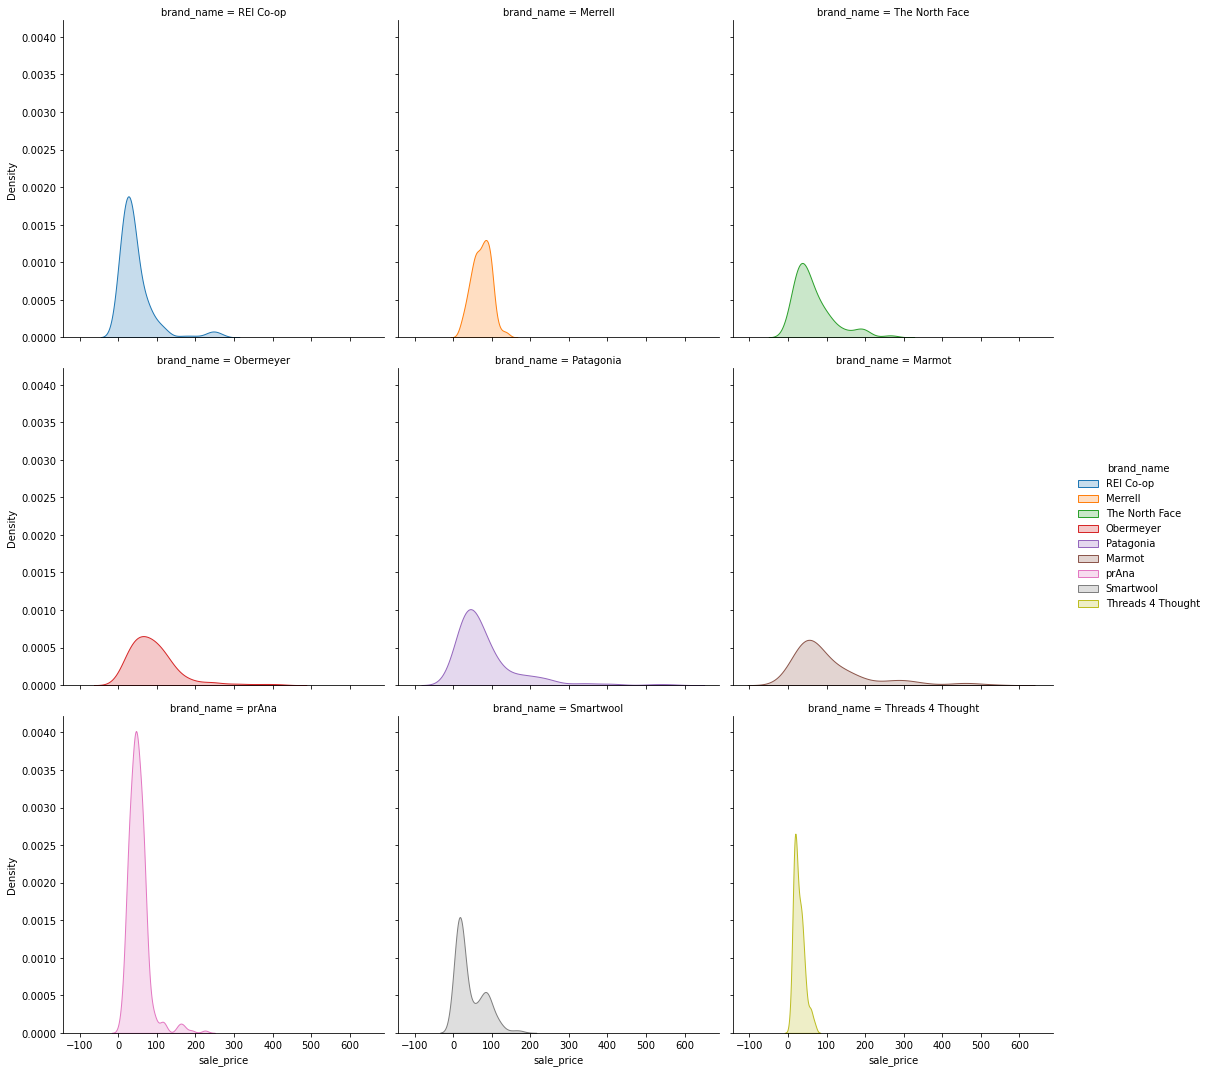

In [75]:
# Brand name and sale price
sns.displot(data=top_brands_data, 
            x='sale_price', 
            hue='brand_name', 
            col='brand_name',
            col_wrap=3,
            kind='kde', 
            fill=True)

Unsurprisingly, the distribution of sale prices from different brands is very variable.

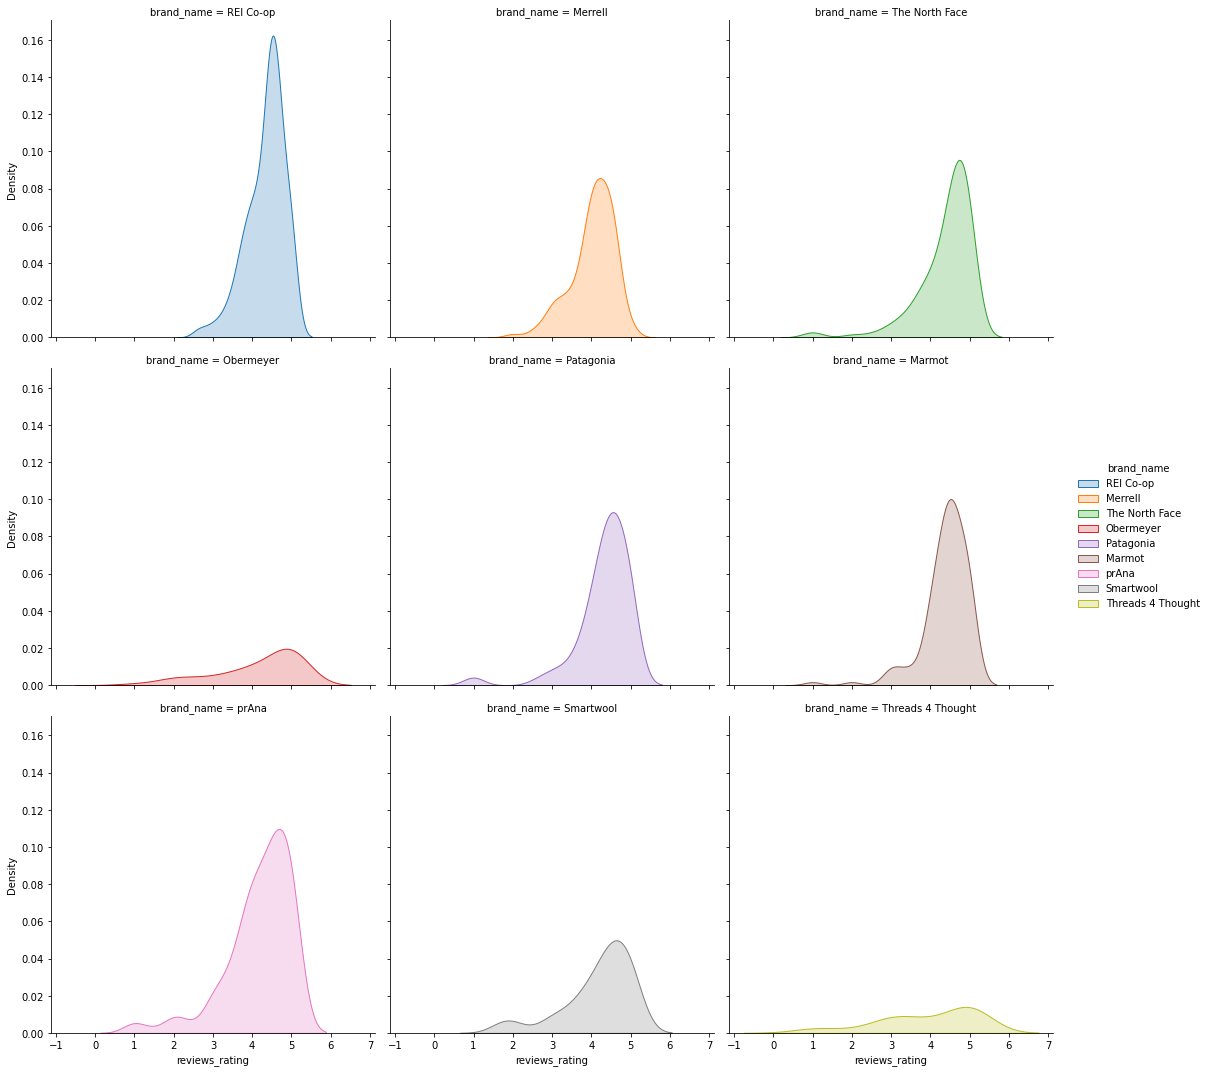

In [76]:
# Brand name and review rating
sns.displot(data=top_brands_data, 
            x='reviews_rating', 
            hue='brand_name', 
            col='brand_name',
            col_wrap=3,
            kind='kde', 
            fill=True)

Review ratings also vary by brand.

## Conclusion

Awesome! So, what have we learned?

We did the following:
- Scraped relevant information from https://www.rei.com.
- Stored the data in a structured dataframe.
- Visualized the data.
- Performed some preliminary hypothesis tests.

What did we find?
- REI likely uses different pricing and discounting strategies for products in men's and women's categories.
- Products with higher reviews are discounted less on average.
- Products tend to be discounted in regular percentages (25%, 30%, 50%), although this varies by brand.
- Review ratings and sale prices vary by brand.
- The number of carousel images displayed is not clearly related to discount percentage, but it is with sale price.

Here are some ideas for future analysis:
- Expand the scraping process to REI's entire catalogue and compare full-price products to discounted products.
- Add product categories to our dataframe.
- Investigate which sizes go on sale most.

And, as promised, what is the second-cheapest Patagonia item to get your mom for her birthday?

In [77]:
deals_data[(deals_data.brand_name=="Patagonia") & (deals_data.gender_category=="Women's")].sort_values('sale_price').iloc[[1]]

,product_name,brand_name,gender_category,sale_price,original_price,number_reviews,reviews_rating,number_images,percent_discount
50,Capilene Cool Daily Graphic Shirt - Women's,Patagonia,Women's,21.83,49.0,36,4.8,5,55.44898


<span style="color:red">DEALS DEALS DEALS DEALS DEALS</span>

## More helpful resources

- https://automatetheboringstuff.com
- https://pandas.pydata.org/docs/
- https://www.crummy.com/software/BeautifulSoup/bs4/doc/
- https://seaborn.pydata.org/api.html